<a href="https://colab.research.google.com/github/iSarahSajjad/neuro-chronical-prediction/blob/Models/Chronic_1_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: connect with google drive and get the file from chronic AI sub folder dataset

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import os


Mounted at /content/drive


In [2]:
main_file_path = '/content/drive/My Drive/ChronicAI/dataset/participants.tsv'

# Read the TSV file into a DataFrame using pandas
main_df = pd.read_csv(main_file_path, sep='\t')

base_dir = '/content/drive/My Drive/ChronicAI/dataset/'

# Create a list to store the combined data
combined_data = []

# Keep only the specified columns
main_df = main_df[['participant_id', 'age', 'origin', 'group']]

# Iterate through each row in the main DataFrame
for index, row in main_df.iterrows():
    participant_id = row['participant_id']

    # Define the path to the participant's directory
    participant_dir = os.path.join(base_dir, str(participant_id))

    # Check if the directory exists
    if os.path.exists(participant_dir):
        # Get a list of all TSV files in the participant's directory
        tsv_files = [f for f in os.listdir(participant_dir) if f.endswith('.tsv')]

        # Iterate through each TSV file
        for tsv_file in tsv_files:
            tsv_file_path = os.path.join(participant_dir, tsv_file)

            # Read the TSV file into a DataFrame
            participant_df = pd.read_csv(tsv_file_path, sep='\t')

            # Add the participant's ID to the DataFrame
            participant_df['participant_id'] = participant_id

            # Append the DataFrame to the combined data list
            combined_data.append(participant_df)

# Combine all the DataFrames in the list into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Merge the combined DataFrame with the main DataFrame on participant_id
final_df = pd.merge(main_df, combined_df, on='participant_id', how='left')

# Display the first few rows of the final DataFrame
print(final_df.head())

  participant_id  age origin     group session_id  days_since_interview  \
0        sub-001   27      4  subacute  interview                   0.0   
1        sub-001   27      4  subacute     visit1                   4.0   
2        sub-001   27      4  subacute     visit2                  94.0   
3        sub-001   27      4  subacute     visit3                   NaN   
4        sub-001   27      4  subacute     visit4                 395.0   

  hours_sleep smoker limited_self_care/mobility bdi_total  ...  pdi_total  \
0      6 to 7      n                          y       1.0  ...          2   
1      6 to 7      n                          n       NaN  ...         17   
2         NaN    NaN                        NaN       NaN  ...         21   
3           7      n                          n       7.0  ...          2   
4         NaN    NaN                        NaN       7.0  ...          2   

   pdetect_pain_now  pdetect_strongest_4wks pdetect_pain_average_4wks  \
0            

In [3]:
import nibabel as nib
from sklearn.preprocessing import LabelEncoder

# Filter data by group
groups = ['healthy', 'chronic', 'subacute']
filtered_dfs = {group: final_df[final_df['group'] == group] for group in groups}

# Initialize lists to store data and labels
all_data = []
all_labels = []

# Function to load and normalize MRI data
def load_and_normalize_mri(file_path):
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))
        return img_data
    except Exception as e:
        print(f"Error loading or normalizing {file_path}: {e}")
        return None

# Process each group
for group in groups:
    df = filtered_dfs[group]
    print(f"Processing group: {group}, Number of participants: {len(df)}")

    for _, row in df.iterrows():
        participant_id = row['participant_id']
        session_id = row['session_id']
        session_folder = f"ses-{session_id}"
        anat_path = os.path.join(base_dir, str(participant_id), session_folder, 'anat')

        if os.path.exists(anat_path):
            for file_name in os.listdir(anat_path):
                if file_name.endswith('.nii'):
                    file_path = os.path.join(anat_path, file_name)
                    img_data = load_and_normalize_mri(file_path)
                    if img_data is not None:
                        all_data.append(img_data)
                        all_labels.append(group)
                    break  # Only one sample per session

# Convert lists to numpy arrays
if all_data:
    all_data = np.array(all_data)
    all_labels = np.array(all_labels)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(all_labels)

    # Save prepared data and labels
    np.save('prepared_mri_data.npy', all_data)
    np.save('prepared_labels.npy', encoded_labels)

    # Print summary
    print(f"Total samples: {len(all_data)}")
    print(f"Unique groups: {label_encoder.classes_}")
else:
    print("No valid MRI data found. Check the data directory and file formats.")

Processing group: healthy, Number of participants: 130
Processing group: chronic, Number of participants: 130
Processing group: subacute, Number of participants: 390


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (434,) + inhomogeneous part.

In [7]:
import nibabel as nib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom
import os

# Filter data by group
groups = ['healthy', 'chronic', 'subacute']
filtered_dfs = {group: final_df[final_df['group'] == group] for group in groups}

# Initialize lists to store data and labels
all_data = []
all_labels = []

# Function to load, normalize, and resize MRI data
def load_and_process_mri(file_path, target_size=(64, 64, 64)):
    try:
        img = nib.load(file_path)
        img_data = img.get_fdata()
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        # Resize to target size if necessary
        if img_data.shape != target_size:
            factors = [t / s for s, t in zip(img_data.shape, target_size)]
            img_data = zoom(img_data, factors, order=1)  # Use zoom from scipy

        return img_data
    except Exception as e:
        print(f"Error loading or processing {file_path}: {e}")
        return None

# Process each group
for group in groups:
    df = filtered_dfs[group]
    print(f"Processing group: {group}, Number of participants: {len(df)}")

    for _, row in df.iterrows():
        participant_id = row['participant_id']
        session_id = row['session_id']
        session_folder = f"ses-{session_id}"
        anat_path = os.path.join(base_dir, str(participant_id), session_folder, 'anat')

        if os.path.exists(anat_path):
            for file_name in os.listdir(anat_path):
                if file_name.endswith('.nii'):
                    file_path = os.path.join(anat_path, file_name)
                    img_data = load_and_process_mri(file_path)
                    if img_data is not None:
                        # Add channel dimension
                        img_data = np.expand_dims(img_data, axis=-1)
                        all_data.append(img_data)
                        all_labels.append(group)
                    break  # Only one sample per session

# Convert data and labels to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)

# Encode labels as integers and then one-hot vectors
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(all_labels)
one_hot_labels = to_categorical(integer_labels, num_classes=len(groups))

# Ensure the correct input shape for Conv3D
input_shape = all_data.shape[1:]  # Exclude the number of samples

# Create a 3D CNN model
model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
    MaxPooling3D((2, 2, 2)),
    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    Conv3D(128, (3, 3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(groups), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(all_data, one_hot_labels, epochs=10, batch_size=32, validation_split=0.2)
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_data, one_hot_labels, test_size=0.2, random_state=42)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Processing group: healthy, Number of participants: 130
Processing group: chronic, Number of participants: 130
Processing group: subacute, Number of participants: 390


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - accuracy: 0.4179 - loss: 2.3288 - val_accuracy: 0.5517 - val_loss: 1.0895
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.6767 - loss: 0.8743 - val_accuracy: 0.5517 - val_loss: 0.9759
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.6641 - loss: 0.8664 - val_accuracy: 0.5517 - val_loss: 0.9944
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.6187 - loss: 0.9279 - val_accuracy: 0.5517 - val_loss: 0.9497
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.6572 - loss: 0.8413 - val_accuracy: 0.5517 - val_loss: 0.9359
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.6378 - loss: 0.8631 - val_accuracy: 0.5517 - val_loss: 0.8863
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.6017 - loss: 0.8949 - val_accuracy: 0.5517 - val_loss: 0.8993
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.6167 - loss: 0.8611 - val_accuracy: 0.

In [8]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5532 - loss: 0.8791
Validation Loss: 0.8621, Validation Accuracy: 0.5517


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.6395 - loss: 0.7871 - val_accuracy: 0.5517 - val_loss: 0.8724
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.6208 - loss: 0.7971 - val_accuracy: 0.5862 - val_loss: 0.9070
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.6989 - loss: 0.7047 - val_accuracy: 0.5862 - val_loss: 0.8608
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.6708 - loss: 0.6979 - val_accuracy: 0.5977 - val_loss: 0.9224
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6508 - loss: 0.6850 - val_accuracy: 0.5862 - val_loss: 1.1591
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6954 - loss: 0.6259 - val_accuracy: 0.4943 - val_loss: 1.1729
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.7134 - loss: 0.6464 - val_accuracy: 0.6207 - val_loss: 1.0289
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.7703 - loss: 0.5328 - val_accuracy: 0.

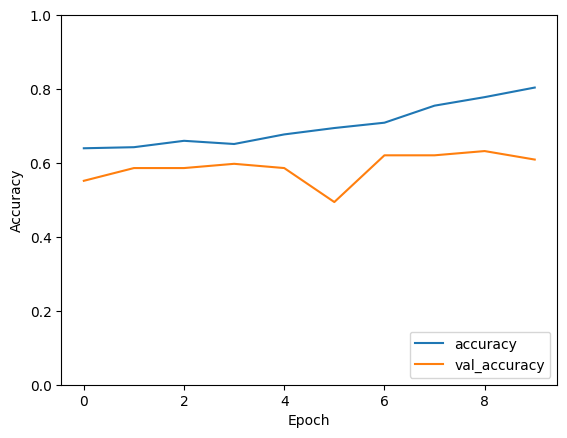

In [9]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [10]:
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

print("Predicted classes:", predicted_classes[:10])
print("True classes:", true_classes[:10])


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
Predicted classes: [0 0 0 2 0 0 2 2 2 2]
True classes: [2 1 0 2 2 2 2 0 2 2]
